# source ; https://towardsdatascience.com/uncovering-the-magic-interpreting-machine-learning-black-box-models-3154fb8ed01a

## Most of the model interpretation techniques were taken from this highly recommendable book from Christoph Molnar: Interpretable Machine Learning - A Guide for Making Black Box Models Explainable. (https://christophm.github.io/interpretable-ml-book/) https://christophm.github.io/interpretable-ml-book/

### good reference with korean ver ; https://elapser.github.io/machine-learning/2019/03/08/Model-Agnostic-Interpretation.html

# - Agenda

## Taxonomy of Interpretability Methods

- Intrinsic or Post-Hoc? This criteria distinguishes whether interpretability is achieved by restricting the complexity of the machine learning model (intrinsic) or by applying methods that analyze the model after training (post-hoc).

- Model-Specific or Model-Agnostic? Linear models have a model-specific interpretation, since the interpretation of the regression weights are specific to that sort of models. Similarly, decision trees splits have their own specific interpretation. Model-agnostic tools, on the other hand, can be used on any machine learning model and are applied after the model has been trained (post-hoc).

- Local or Global? Local interpretability refers to explaining an individual prediction, whereas global interpretability is related to explaining the model general behavior in the prediction task. Both types of interpretations are important and there are different tools for addressing each of them.

In [4]:
import os
import numpy as np 
import pandas as pd 
import xgboost as xgb
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from pdpbox import pdp, get_dataset, info_plots
import eli5
from eli5.sklearn import PermutationImportance
import shap
import lime
from lime import lime_tabular
from lime import submodular_pick
from fairml import audit_model
from fairml import plot_dependencies
from utils import clf_metrics

%matplotlib inline

In [2]:
data = pd.read_csv('datasets/adult.csv', encoding='utf-8')

In [3]:
data.head(5)

age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

### XGBoost

#### EDA + Feature Engineering

In [5]:
# Target
data.loc[:, 'income'] = data['income'].apply(lambda x: 0 if x == '<=50K' else 1)

In [7]:
data.head(10)

age    workclass  fnlwgt     education  education.num marital.status  \
0   90            ?   77053       HS-grad              9        Widowed   
1   82      Private  132870       HS-grad              9        Widowed   
2   66            ?  186061  Some-college             10        Widowed   
3   54      Private  140359       7th-8th              4       Divorced   
4   41      Private  264663  Some-college             10      Separated   
5   34      Private  216864       HS-grad              9       Divorced   
6   38      Private  150601          10th              6      Separated   
7   74    State-gov   88638     Doctorate             16  Never-married   
8   68  Federal-gov  422013       HS-grad              9       Divorced   
9   41      Private   70037  Some-college             10  Never-married   

          occupation    relationship   race     sex  capital.gain  \
0                  ?   Not-in-family  White  Female             0   
1    Exec-managerial   Not-in-family  White  Female             0   
2                  ?       Unmarried  Black  Female             0   
3  Machine-op-inspct       Unmarried  White  Female             0   
4     Prof-specialty       Own-child  White  Female             0   
5      Other-service       Unmarried  White  Female             0   
6       Adm-clerical       Unmarried  White    Male             0   
7     Prof-specialty  Other-relative  White  Female             0   
8     Prof-specialty   Not-in-family  White  Female             0   
9       Craft-repair       Unmarried  White    Male             0   

   capital.loss  hours.per.week native.country  income  
0          4356              40  United-States       0  
1          4356              18  United-States       0  
2          4356              40  United-States       0  
3          3900              40  United-States       0  
4          3900              40  United-States       0  
5          3770              45  United-States       0  
6          3770              40  United-States       0  
7          3683              20  United-States       1  
8          3683              40  United-States       0  
9          3004              60              ?       1

In [17]:
print(data['marital.status'].unique())
print(data['marital.status'].nunique())

['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']
7


In [19]:
# Workclass
data['workclass'] = data['workclass'].replace(["?"],'Unknown')
# Matrial.status
data['marital.status'] = data['marital.status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 1)
data['marital.status'] = data['marital.status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed'], 0)
# Native country
data['native.country'] = data['native.country'].replace(['?'], 'Unknown')

In [22]:
# Variable selection and One-hot encoding
colNum = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'income']
# prefix argument means that when occurs deviation variables concate them designated words 
# drop_first argument means droping first column 
data_model = pd.concat([data[colNum], 
                        pd.get_dummies(data['workclass'], drop_first = True, prefix = 'class'),
                        pd.get_dummies(data['marital.status'], drop_first = True, prefix = 'married'),
                        pd.get_dummies(data['native.country'], drop_first = True, prefix = 'nac'),
                        pd.get_dummies(data['relationship'], drop_first = True, prefix = 'rel'),
                        pd.get_dummies(data['race'], drop_first = True, prefix = 'race'),
                        pd.get_dummies(data['sex'], drop_first = True, prefix = 'sex'),], axis = 1)

In [21]:
data_model.head()

age  fnlwgt  education.num  capital.gain  capital.loss  hours.per.week  \
0   90   77053              9             0          4356              40   
1   82  132870              9             0          4356              18   
2   66  186061             10             0          4356              40   
3   54  140359              4             0          3900              40   
4   41  264663             10             0          3900              40   

   income  class_Local-gov  class_Never-worked  class_Private  ...  \
0       0                0                   0              0  ...   
1       0                0                   0              1  ...   
2       0                0                   0              0  ...   
3       0                0                   0              1  ...   
4       0                0                   0              1  ...   

   rel_Not-in-family  rel_Other-relative  rel_Own-child  rel_Unmarried  \
0                  1                   0              0              0   
1                  1                   0              0              0   
2                  0                   0              0              1   
3                  0                   0              0              1   
4                  0                   0              1              0   

   rel_Wife  race_Asian-Pac-Islander  race_Black  race_Other  race_White  \
0         0                        0           0           0           1   
1         0                        0           0           0           1   
2         0                        0           1           0           0   
3         0                        0           0           0           1   
4         0                        0           0           0           1   

   sex_Male  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 67 columns]

#### Model Training

In [27]:
# Train/Test Split
target_col = 'income'

In [28]:
X_train , X_test, y_train, y_test = train_test_split(data_model.drop(target_col , axis = 1),
                                                    data_model[target_col],
                                                    shuffle=True, random_state=1984, test_size=0.2)

In [29]:
# Model training ( Train Dataset in DataFrame format)
clf_xgb_df = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 800, max_depth = 4, learning_rate = 0.05 , seed = 1984)
clf_xgb_df.fit(X_train, y_train, eval_metric='auc', verbose=False)

XGBClassifier(learning_rate=0.05, max_depth=4, n_estimators=800, seed=1984)

In [57]:
## Model training (Train Dataset in Array format)
clf_xgb_array = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators= 800, max_depth= 4, 
                              learning_rate= 0.05, seed = 1984)

clf_xgb_array.fit(X_train.values, y_train, eval_metric="auc", verbose=False)

XGBClassifier(learning_rate=0.05, max_depth=4, n_estimators=800, seed=1984)

In [30]:
# Prediction
y_pred_train = clf_xgb_df.predict(X_train)
y_proba_train = clf_xgb_df.predict_proba(X_train)[: , 1]
y_pred_test = clf_xgb_df.predict(X_test)
y_proba_test = clf_xgb_df.predict_proba(X_test)[: , 1]

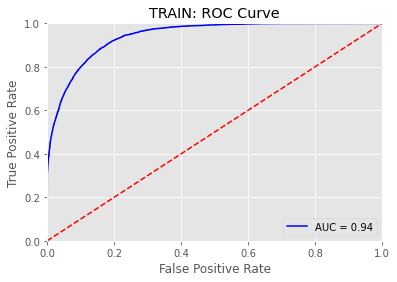

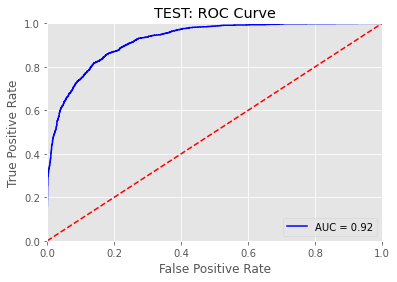

Accuracy  Precision  Recall    F1       AUC
Train      0.88       0.81    0.67  0.73  0.942355
Test       0.87       0.80    0.64  0.71  0.924199

In [31]:
# Metrics
clf_metrics(y_pred_train, y_proba_train, y_train, y_pred_test, y_proba_test, y_test)

#### Mean Decrease Impurity

___Feature Importance (XGBoost)___

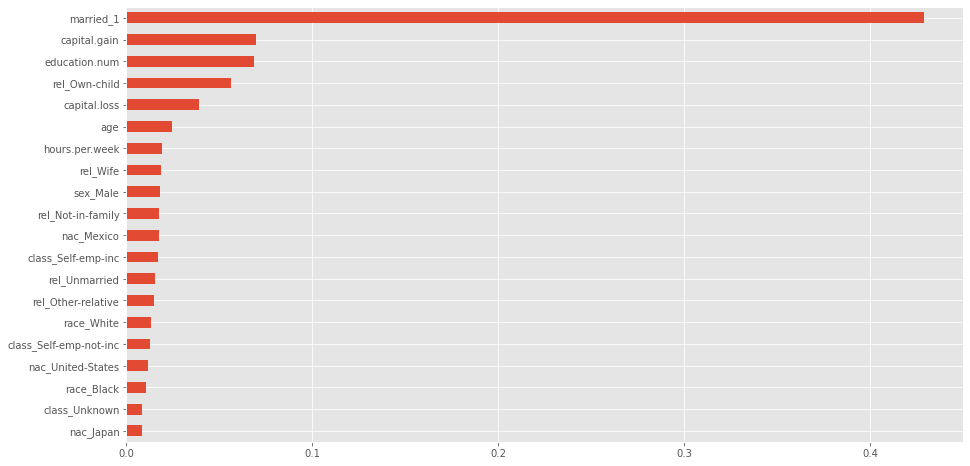

In [35]:
feat_importances = pd.Series(clf_xgb_df.feature_importances_, index = X_train.columns).sort_values(ascending=True)
feat_importances.tail(20).plot(kind='barh',figsize=(15,8))

___Feature Importance (SHAP)___

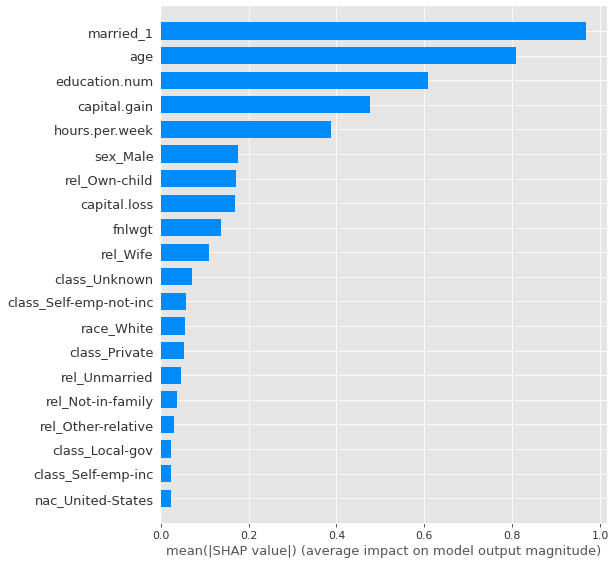

In [36]:
explainer = shap.TreeExplainer(clf_xgb_df)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type = 'bar')

The XGBoost feature importance was used to evaluate the relevance of the predictors in the model's outputs for the Train dataset and the SHAP one to evaluate it for Test dataset, in order to assess if the most important features were similar in both approaches.

It is observed that the most important variables of the model are maintained, although in different order of importance (age seems to take much more relevance in the SHAP approach)

### Summary Plot (SHAP)

#### The SHAP Summary Plot is a very interesting plot to evaluate the features of the model, since it provides more information than the traditional Feature Importance:

    - Feature Importance: variables are sorted in descending order of importance.
    
    - Impact on Prediction: the position on the horizontal axis indicates whether the values of the dataset instances for each feature have more or less impact on the output of the model.
    
    - Original Value: the color indicates, for each feature, whether it is a high or low value (in the range of each of the feature).
    
    - Correlation: the correlation of a feature can be analyzed by evaluating its color (its range of values) and the impact on the horizontal axis. For example, it is observed that the age has a positive correlation, since the impact on the output increases as the value of the feature increases.

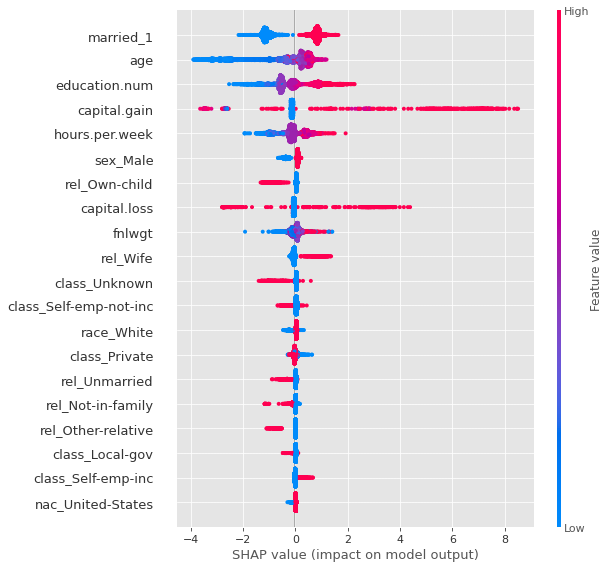

In [37]:
shap.summary_plot(shap_values, X_test)

#### Permutation Importance (ELI5)

Another way to assess the global importance of the predictors is to randomly permute the order of the instances for each feature in the dataset and predict with the trained model. If by doing this disturbance in the order, the evaluation metric does not change substantially, then the feature is not so relevant. If instead the evaluation metric is affected, then the feature is considered important in the model.

To evaluate the trained XGBoost model, the AUC of the ROC Curve will be used as a performance metric. Permutation Importance will be analyzed in both Train and Test

In [39]:
# Train
perm = PermutationImportance(clf_xgb_df , scoring = 'roc_auc', random_state=1984).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

In [40]:
# Test 
perm = PermutationImportance(clf_xgb_df , scoring = 'roc_auc', random_state=1984).fit(X_test , y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Although the order of the most important features changes, it looks like that the most relevant ones remain the same. It is interesting to note that, unlike the XGBoost Feature Importance, the age variable in the Train set has a fairly strong effect (as showed by SHAP Feature Importance in the Test set). Furthermore, the 6 most important variables according to the Permutation Importance are kept in Train and Test (the difference in order may be due to the distribution of each sample).

The coherence between the different approaches to approximate the global importance generates more confidence in the interpretation of the model's output.

### Partial Dependence Plot

The Partial Dependence Plot (PDP) indicates the marginal effect that a feature has individually on the predicted output. For this, the feature is modified, ceteris paribus, and the changes in the mean prediction are observed. The process carried out is as follows:

1) Select feature

2) Define grid of values

3) For each value of the grid:

    a) Replace feature with grid value
    
    b) Average predictions
    
4) Plot curve

The PDP can indicate if the relationship between the feature and the output is linear, monotonic or if it is more complex. It is relevant to note that the observed relationship is with the prediction, but not with the target variable. However, depending on the performance of the model, an intuition of the dependence of the target for the evaluated feature could be generated.

The advantage of PDP is that it is very easy to implement and it is quite intuitive: the function in a particular feature represents the average prediction if all data points are forced to assume each particular value of the feature.

On the other hand, PDP has a number of disadvantages:

    - Does not take into consideration the distribution of the feature: it can be misleading, since it is possible to misinterpret regions with very little data (by allocating all the data points with these values, the value of the feature is being over-represented, which may lead to erroneous conclusions).
    
    - Assumption of independence of the features: it is one of the biggest drawbacks of PDP. It is assumed that the feature for which the partial dependence is computed is not correlated with the rest of the predictors.
    
    - Heterogeneous effects may be hidden: this is because only average marginal effects are computed. At the limit, the PDP could be a horizontal line, with the values evenly distributed above and below, concluding that the feature has no effect on the prediction. These effects can be identified by ploting Individual Conditional Expectation (ICE) curves.

To overcome some of the disadvantages of PDPs, Individual Conditional Expectation (ICE) and Accumulated Local Effects (ALE) plots can be used.

### Individual Conditional Expectation (ICE)

ICE Plot is the PDP equivalent for individual data points. The plot displays a line for each instance of the dataset, indicating how the prediction of that instance varies as the value of the feature varies. A PDP is an average of all the lines in an ICE Plot. The ICE Plots allow to visualize the variance in the marginal effects, being able to detect the heterogeneous effects.

### Accumulated Local Effects (ALE) Plot

PDPs present serious problems when a feature is highly correlated with other predictors, since synthetic instance predictions that are very unlikely to happen in reality are averaged (for example, it would be very unlikely that age were 16 and education.num were 10 simultaneously). This can generate a significant bias when estimating the effect of the feature. ALE Plots, in addition to being computed more quickly, are an unbiased solution to calculate the effect of a feature on model predictions, since they evaluate over its conditional distribution. That is, for a value x1 of the grid, they estimate using only the predictions of the instances that have a value similar to x1, thus avoiding the use of improbable instances in reality.

Furthermore, in order to estimate the effect of a feature on the prediction, instead of using the average (which mixes the effect of the feature with the effects of all the correlated predictors), they calculate the differences between predictions.

#### Differences between ICE and ALE

The ICE solves the problem of heterogeneous effects that PDPs can present, but not the bias due to correlated features. Instead, ALE solves bias problems, taking into consideration the conditional distribution of the feature and its correlation with the rest of the predictors.

We will analyze Partial Dependence Plots using PDPBox and SHAP

#### PDPBox

The PDP for the 4 most relevant observed features will be analyzed:

1. married_1
2. capital.gain
3. education.num
4. age



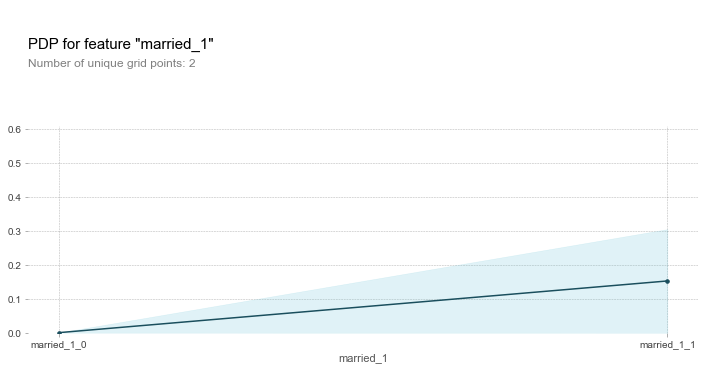

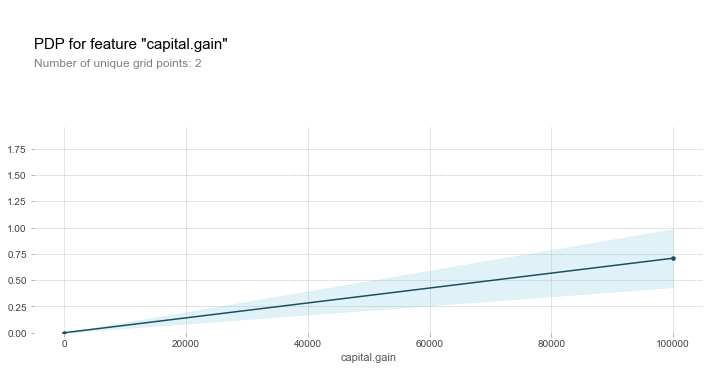

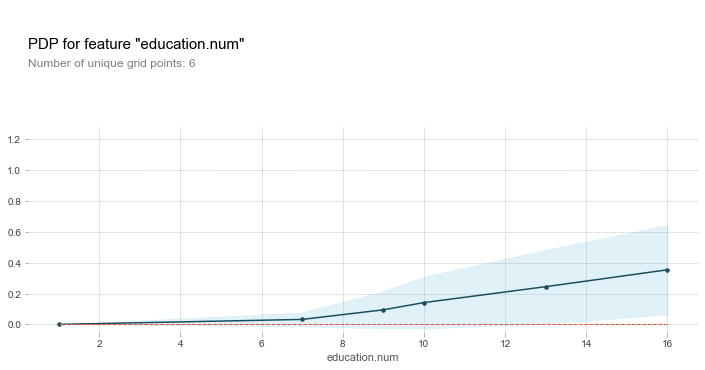

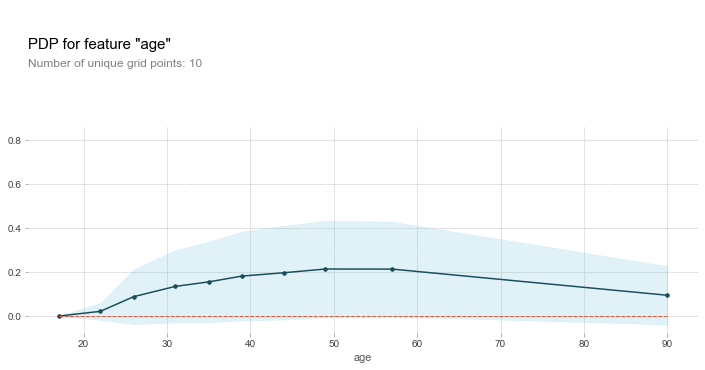

In [41]:
# Create the data that we will plot
pdp_married = pdp.pdp_isolate(model=clf_xgb_df, dataset=X_test, model_features=X_test.columns, feature='married_1')
pdp_capital = pdp.pdp_isolate(model=clf_xgb_df, dataset=X_test, model_features=X_test.columns, feature='capital.gain')
pdp_education = pdp.pdp_isolate(model=clf_xgb_df, dataset=X_test, model_features=X_test.columns, feature='education.num')
pdp_age = pdp.pdp_isolate(model=clf_xgb_df, dataset=X_test, model_features=X_test.columns, feature='age')

# Plot it
pdp.pdp_plot(pdp_married, 'married_1', figsize=(12, 6))
pdp.pdp_plot(pdp_capital, 'capital.gain', figsize=(12, 6))
pdp.pdp_plot(pdp_education, 'education.num',figsize=(12, 6))
pdp.pdp_plot(pdp_age, 'age', figsize=(12, 6))
plt.show()

#### SHAP Dependence Plot
The same PD plots will be generated using the SHAP approach. This library, in addition to indicating the marginal effect of the feature on the model's output, also indicates by color the relationship with the feature with which it most interacts.

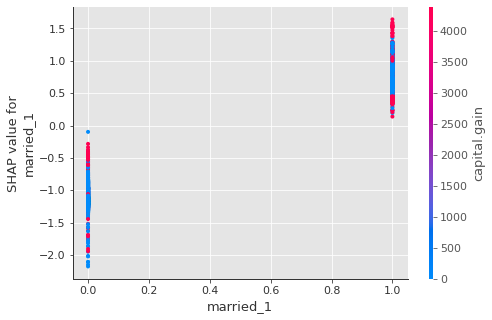

In [42]:
shap.dependence_plot('married_1', shap_values, X_test)

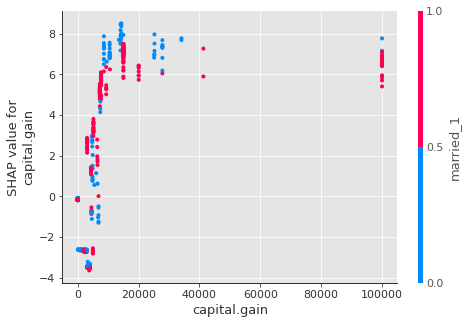

In [43]:
shap.dependence_plot('capital.gain', shap_values, X_test)

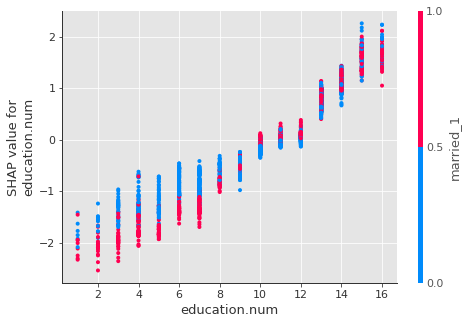

In [44]:
shap.dependence_plot('education.num', shap_values, X_test)

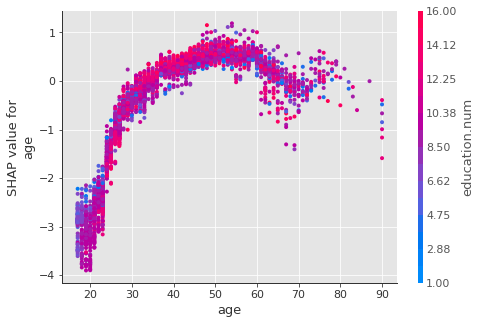

In [45]:
shap.dependence_plot('age', shap_values, X_test)

### Global Surrogate Model

A global surrogate model is an interpretable model that is trained to approximate the predictions of a black box model. we can draw conclusions about the black box model by interpreting the surrogate model.


#### Logistic Regression

In [46]:
log_clf = LogisticRegression().fit(X_train, y_train)

In [47]:
## Predictions
y_pred_train_log = log_clf.predict(X_train)
y_proba_train_log = log_clf.predict_proba(X_train)[:, 1]
y_pred_test_log = log_clf.predict(X_test)
y_proba_test_log = log_clf.predict_proba(X_test)[:, 1]

In [48]:
print('R-squared Train RL-XGB: ', r2_score(y_proba_train_log, y_proba_train))
print('R-squared Train RL-XGB: ', r2_score(y_proba_test_log, y_proba_test))

R-squared Train RL-XGB:  -1.5591253572424026
R-squared Train RL-XGB:  -1.6849939052576701


The R-squared is negative for both Train and Test sets. This happens when the fit is worse than simply using the mean. Therefore, it is concluded that _Logistic Regression is not a good surrogate model._

#### Decision Tree

In [51]:
tree_clf = tree.DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train, y_train)

R-squared Train DT-XGB:  0.7199434946736618
R-squared Test DT-XGB:  0.7145484050221179


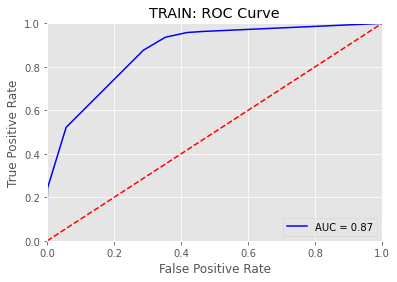

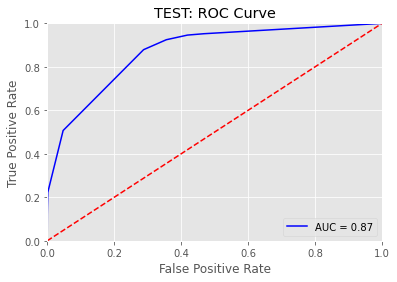

Accuracy  Precision  Recall    F1       AUC
Train      0.84       0.74    0.52  0.61  0.874041
Test       0.84       0.78    0.51  0.61  0.869740

In [52]:
## Predictions
y_pred_train_tr = tree_clf.predict(X_train)
y_proba_train_tr = tree_clf.predict_proba(X_train)[:, 1]
y_pred_test_tr = tree_clf.predict(X_test)
y_proba_test_tr = tree_clf.predict_proba(X_test)[:, 1]

## r2
print('R-squared Train DT-XGB: ', r2_score(y_proba_train_tr, y_proba_train))
print('R-squared Test DT-XGB: ', r2_score(y_proba_test_tr, y_proba_test))

## Metricas
clf_metrics(y_pred_train_tr, y_proba_train_tr, y_train, y_pred_test_tr, y_proba_test_tr, y_test)

__The variance in the XGBoost model predictions is fairly well approximated by the Decision Tree, so it can serve as a surrogate model for interpreting the main model.__

In fact, the performance metrics are also quite close to the original model.

It is important to note that while the variance of the XGBoost predictions is well explained by the Decision Tree, it is not guaranteed that the latter uses the features in the same way as the former. It could happen that the Tree approximates the XGBoost correctly in some areas of the input space, but behaves drastically differently in other regions.

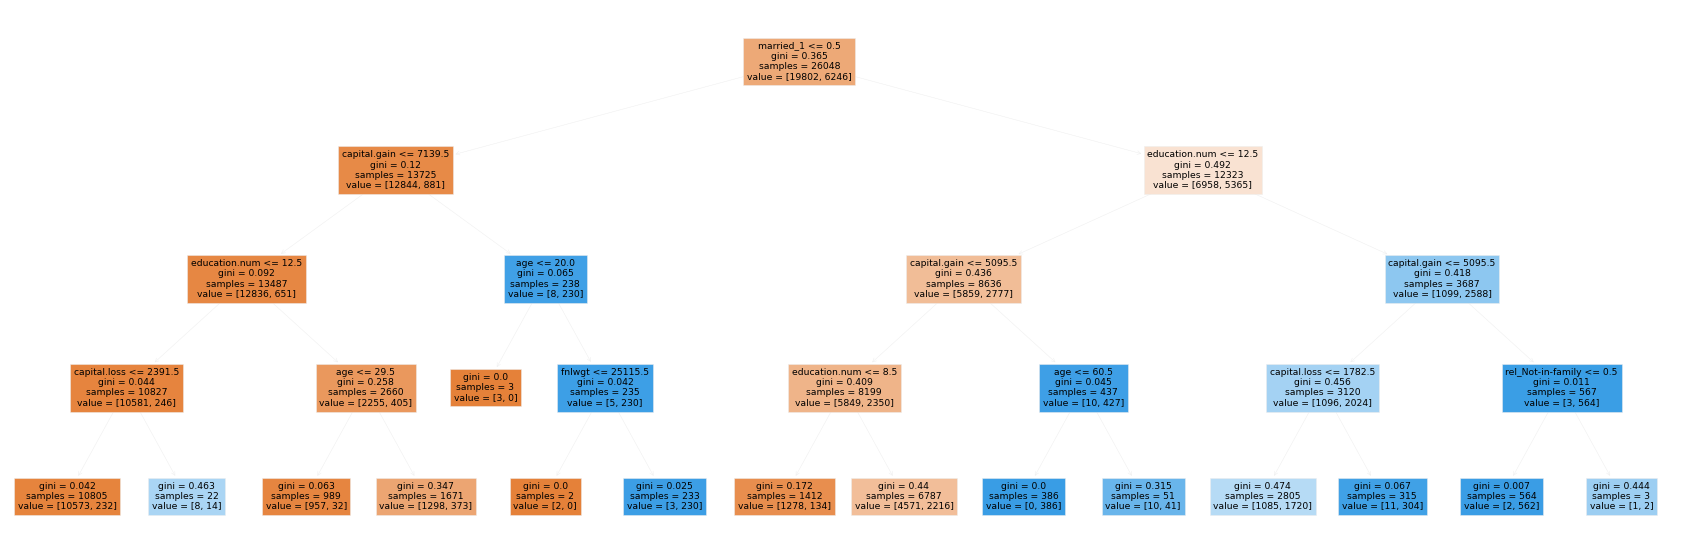

In [53]:
fig, ax = plt.subplots(figsize=(30, 10)) 
tree.plot_tree(tree_clf, feature_names= X_train.columns.to_list(), ax=ax, filled=True)
plt.show()



The 5 features that the tree used to estimate the Income, in order of importance, are:

1. married_1
2. education.num
3. capital.gain
4. capital.loss
5. age

These features correspond to the most important ones that have been detected by other methodologies.


#### Local Importance
Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models.

##### Local Interpretability (LIME)
Local Interpretable Model-agnostic Explanations (LIME) analyzes what happens in model predictions when variations are made to the input data. It generates a new dataset with permuted samples and their corresponding predictions from the original model. On this synthetic set LIME trains interpretable models (Logistic Regression, Decision Tree, LASSO, etc.), which are then weighted by the proximity of the sampled instances to the instance of interest.

__The explanation for instance X will be that of the surrogate model that minimizes the loss function (performance measure -i.e. MSE- between the prediction of the surrogate model and the prediction of the original model), keeping the complexity of the model low.__

In [55]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='classification',
                                                   feature_names=X_train.columns.tolist(),
                                                   discretize_continuous=False, random_state=1984)

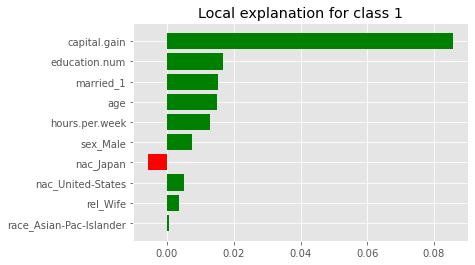

In [58]:
# Generate an explanation
i = 546
exp = explainer.explain_instance(X_test.values[i], clf_xgb_array.predict_proba)

%matplotlib inline
fig = exp.as_pyplot_figure();

In [59]:
sp_obj = submodular_pick.SubmodularPick(explainer, X_test.values, clf_xgb_array.predict_proba, sample_size=3, num_exps_desired=3)

In [60]:
[exp.show_in_notebook() for exp in sp_obj.sp_explanations]

[None, None, None]

It is observed that the most influential feature in all individual interpretations to separate the classes in _capital.gain_. Following this, depending on the instance, the predictors of greatest relevance are _married, education.num, age and sex._ These features are the same that were identified in the algorithms of global importance.

#### Local Interpretability (SHAP) 

SHAP (SHapley Additive exPlanations) is a method to explain individual predictions based on the calculation of Shapley Values, a method from coalitional game theory. It seeks to answer the question __"How much has each feature value contributed to the prediction, relative to the average prediction?".__ To do this, the Shapley Values assign "payments" to "players" depending on their contribution to the "total payment". Players cooperate in a coalition and receive certain rewards for such cooperation.

In the machine learning context, the "game" is the prediction task for an instance of the dataset. The "total payment" is the prediction for that instance, minus the average prediction for the entire dataset. The "players" are the values of the features for the instance, which cooperate in a coalition to receive the "payment" (the prediction). The Shapley Value is the average marginal contribution of a feature value for all possible coalitions. It indicates how the "total payout" (prediction) is distributed among all "players" (the feature values).

One innovation that SHAP brings to the table is that the Shapley value explanation is represented as an additive feature attribution method, namely a linear model. In this way, __SHAP connects the benefits of LIME with the Shapley Values.__

__The great advantage of SHAP is its contribution to the field of interpretable Machine Learning. This is so since here the global interpretations are consistent with the individual explanations, since the Shapley Values are the "atomic unit" of the global interpretations (which have a solid theoretical foundation in Game Theory). If, for example, LIME were used for local explanations and PDP or Permutation Importance for global interpretations, there is no common theoretical foundation between the methods.__



In [61]:
explainer = shap.TreeExplainer(clf_xgb_df, model_output='probability', feature_dependence='independent', data = X_test)

##### Force Plot

In [62]:
row_to_show = 150
data_for_prediction = X_test.iloc[row_to_show, :]

shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

__Visualization omitted, Javascript library not loaded!__


Have you run `initjs()` in this notebook? If this notebook was from another user you must also trust this notebook (File -> Trust notebook). If you are viewing this notebook on github the Javascript has been stripped for security. If you are using JupyterLab this error is because a JupyterLab extension has not yet been written. 

The force plot indicates, for each feature, the impact it had on the prediction. There are two relevant values to notice: the output value (model prediction for the instance) and the base value (average prediction for the entire dataset). A bigger bar means a higher impact and the color indicates if the feature moved the prediction from the base value towards 1 (red) or 0 (blue).

##### Decision Plot

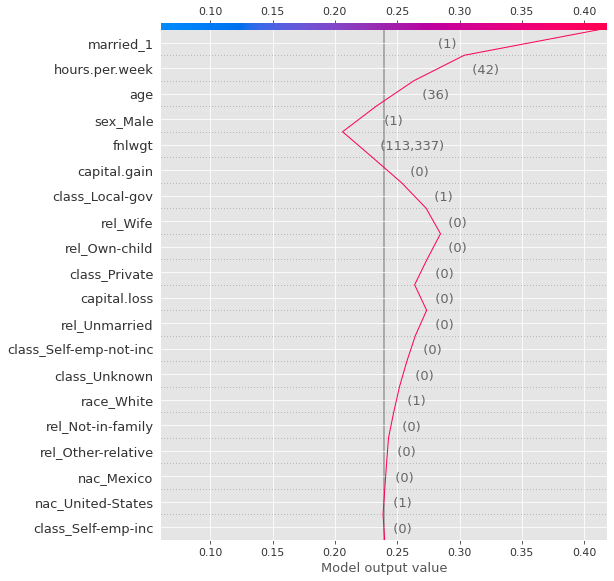

In [63]:
shap.decision_plot(explainer.expected_value, shap_values, data_for_prediction)



The Decision Plot shows essentially the same information than the Force Plot. The grey vertical line is the base value and the red line indicates if each feature moved the output value to a higher or lower value than the average prediction.

This plot can be a little bit more clear and intuitive than the previous one, especially when there are many predictors to analyze. In the Force Plot the information may look very condensed when the number of features is high.


#### Model Fairness

Like most interpretation algorithms, the basic idea behind FairML is to measure how the model's predictions vary with perturbations in the inputs. If a small change in a feature dramatically modifies the output, then the model is sensitive to that feature.

However, if the features are correlated, the indirect effects between them might still not be accounted for in the interpretation model. __FairML addresses this multicollinearity problem using orthogonal projection.__

__Orthogonal Projection__

An orthogonal projection is a type of vector projection that maps a vector onto the orthogonal (perpendicular) direction of another vector. If a vector a is projected onto a vector b (in Euclidean space), the component of a that lies in the direction of b is obtained. This concept is very important in FairML since it allows to completely remove the linear dependence between features. If 2 vectors are orthogonal to each other, then there is no linear combination of one vector that can produce the other. The component of a orthogonal to b, can be calculated as a2 = a - a1 	proyeccion_ortogonal.PNG


__FairML Process 	__
FairML.PNG ; 
If F is a model trained with 2 features x e y, to calculate the dependence of F on x, firstly y is made orthogonal to x to remove all dependencies between the two. Secondly, the variation in the model output is analyzed using the orthogonal component of y and making perturbations in x. The change in output between the perturbed input and the original input indicates the dependence of the model on x. The dependence of F on y can be estimated in the same way.

__Orthogonal Projection guarantees that there will be no hidden collinearity effects.__

It is important to note that this is a linear transformation, so it does not account for non-linear dependencies between features. To solve this, FairML uses basis expansion and a greedy search over such expansions.


In [64]:
# Model audit
# This procedure has a lot time for utilizing
importances, _ = audit_model(clf_xgb_array.predict, X_train, distance_metric="mse")

In [66]:
importances_dict={i:np.mean(np.array(f).astype(np.float)) for i,f in importances.items()}
pd.DataFrame(importances_dict, index=['Importance']).transpose().sort_values(by='Importance', ascending=False)

Importance
hours.per.week            0.177403
education.num             0.176943
fnlwgt                    0.171990
married_1                 0.166615
race_White                0.163007
...                            ...
class_State-gov          -0.009790
class_Self-emp-not-inc   -0.013168
class_Local-gov          -0.016700
class_Private            -0.107494
age                      -0.176827

[66 rows x 1 columns]

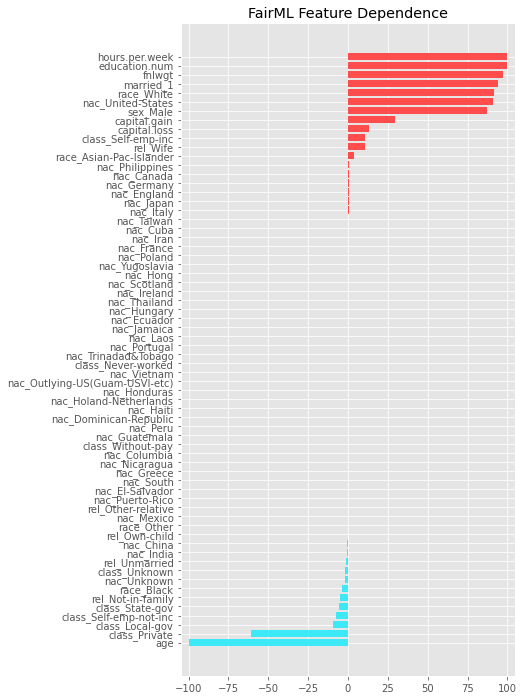

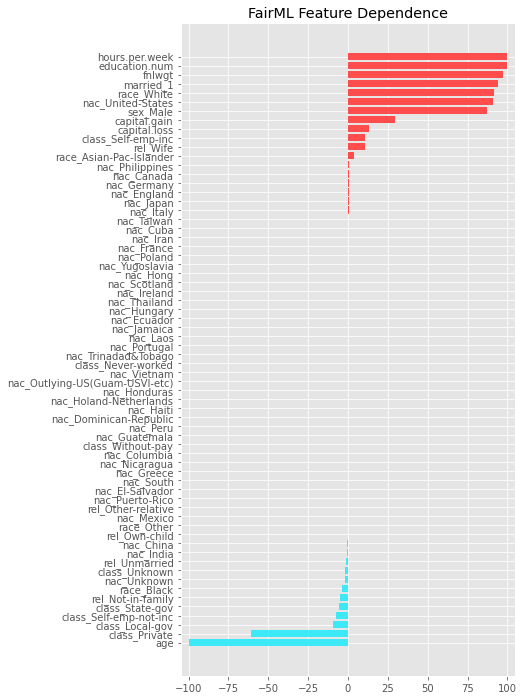

In [67]:
plot_dependencies(
    importances.median(),
    reverse_values=False,
    title="FairML Feature Dependence",
    fig_size=(6,12)
)



FairML allows to plot the dependence of the output on each feature (excluding the effect of the correlation with the other predictors). Red bars indicate that the feature contributes to an output 1 (Income > 50K), while light blue bars indicate that it contributes to an output 0 (Income <= 50K).

It is observed that this algorithm, by removing the dependence between features through orthogonal projection, identifies that the model has a high dependence on sensitive features such as race_White, nac_United-States and sex_Male. In other words, according to the trained model, a white man born in the United States will have a high probability of having an income greater than USD 50,000, which constitutes a very strong bias.

__It is very important to notice the relevance of the orthogonal projection in the algorithm, since features such as race_White and nac_United-States did not appear to be so relevant in the other interpretation algorithms. This is probably because the effects of these are hidden in other features. By removing multicollinearity and evaluating the individual dependence on each feature, it is possible to identify the intrinsic effects of each one.__


# In summary, the libraries and techniques used are:

    XGBoost: Feature Importance
    
    ELI5: Permutation Importance
    
    PDPBox: Partial Dependence Plot
    
    Global Surrogate Model: Logistic Regression, Decision Tree
    
    LIME: Local Importance
    
    SHAP: Feature Importance, Summary Plot, Partial Dependence Plot, Local Importance
    

#### Below code exists for util which is using evaluation metrics 

In [ ]:
'''
def clf_metrics(y_pred_train, y_proba_train, y_train, y_pred_test, y_proba_test, y_test):
    """ Generates dataframe with kpis for classification models
     Parameters:
     y_pred_train: model binary train prediction
     y_proba_train: model train probability prediction
     y_train : model true train target values
     y_pred_test: model binary test prediction
     y_proba_train: model  probability test prediction
     y_test : model true test target values
     Returns:
     dataframe  with Accuracy, Precision, Recall, F1, AUC for train and test predictions
    """

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve
    import pandas as pd
    import matplotlib.pyplot as plt

    y_pred_train = pd.Series(y_pred_train).reset_index(drop=True).copy()
    y_proba_train = pd.Series(y_proba_train).reset_index(drop=True).copy()
    y_train = pd.Series(y_train).reset_index(drop=True).copy()

    y_pred_test = pd.Series(y_pred_test).reset_index(drop=True).copy()
    y_proba_test = pd.Series(y_proba_test).reset_index(drop=True).copy()
    y_test = pd.Series(y_test).reset_index(drop=True).copy()

    fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Results

    train_accuracy = round(accuracy_score(y_train, y_pred_train), 2)
    train_precision = round(precision_score(y_train, y_pred_train), 2)
    train_recall = round(recall_score(y_train, y_pred_train), 2)
    train_f1 = round(f1_score(y_train, y_pred_train), 2)

    test_accuracy = round(accuracy_score(y_test, y_pred_test), 2)
    test_precision = round(precision_score(y_test, y_pred_test), 2)
    test_recall = round(recall_score(y_test, y_pred_test), 2)
    test_f1 = round(f1_score(y_test, y_pred_test), 2)

    train_results = pd.concat([pd.Series(train_accuracy), pd.Series(train_precision), pd.Series(train_recall),
                               pd.Series(train_f1), pd.Series(roc_auc_train)], axis=1)

    test_results = pd.concat([pd.Series(test_accuracy), pd.Series(test_precision), pd.Series(test_recall),
                              pd.Series(test_f1), pd.Series(roc_auc_test)], axis=1)

    results = train_results.append(test_results)
    results.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    results.index = ['Train', 'Test']

    # Curva ROC
    # Train
    plt.title('TRAIN: ROC Curve')
    plt.plot(fpr_train, tpr_train, 'b', label='AUC = %0.2f' % roc_auc_train)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # Test

    plt.title('TEST: ROC Curve')
    plt.plot(fpr_test, tpr_test, 'b', label='AUC = %0.2f' % roc_auc_test)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return results
'''